<a href="https://colab.research.google.com/github/myselfdk03/ml-model/blob/main/spam_detection_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()  # This will prompt you to upload kaggle.json

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d uciml/sms-spam-collection-dataset

import zipfile
import os

for file in os.listdir():
    if file.endswith(".zip"):
        with zipfile.ZipFile(file, 'r') as zip_ref:
            zip_ref.extractall("dataset")  # Extract to "dataset" folder

import os
print(os.listdir("dataset"))


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset
License(s): unknown
100% 211k/211k [00:00<00:00, 751kB/s]
100% 211k/211k [00:00<00:00, 750kB/s]
['spam.csv']


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:

df = pd.read_csv("dataset/spam.csv", encoding="latin-1")  # Try 'latin1' or 'utf-16' if needed
df.head()


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [ ]:
df.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [ ]:
df.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [ ]:
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
df['target'] = df['v1'].map({'ham':0, 'spam':1})
df.head()

,v1,v2,target
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


Check the quantity of SPAMs


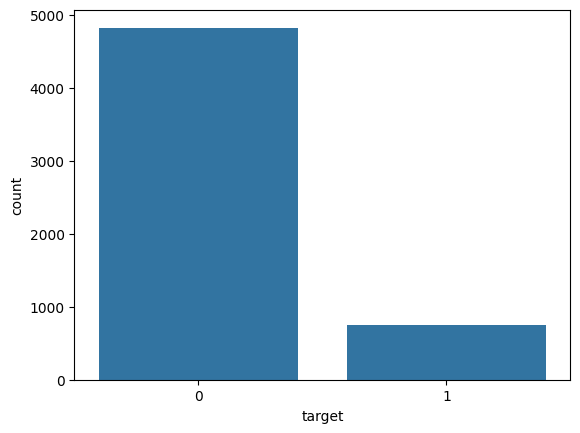

In [ ]:
sns.countplot(x=df['target'])
plt.show()

data balancing not required as we are using embeddings

In [ ]:
# average number of words  in all sentences
df['num_words'] = df['v2'].apply(lambda x: len(x.split()))
avg = round(df['num_words'].mean())

In [ ]:
# fin total number of unique words in corpus
unique_words = set()
for sent in df['v2']:
  for word in sent.split():
    unique_words.add(word)
total_words_length=len(unique_words)
print(total_words_length)

15585


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
x = vectorizer.fit_transform(df['v2'])

In [ ]:
# import LabelEncoder
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['target'] = label_encoder.fit_transform(df['target'])

Model Building

In [ ]:
# split data into training and testing parts using train_test_split
from sklearn.model_selection import train_test_split

y = df['target']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4457, 8672), (4457,), (1115, 8672), (1115,))

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


classifiers = [
    MultinomialNB(),
    RandomForestClassifier(),
    KNeighborsClassifier(),
    SVC()]

for classifier in classifiers:
  classifier.fit(X_train,y_train)

pipe_dict = {0:'MultinomialNB',1:'RandomForestClassifier',2:'KNeighborsClassifier',3:'SVC'}

In [ ]:
from sklearn.model_selection import cross_val_score

for i, model in enumerate(classifiers):
  cv_score = cross_val_score(model, X_train,y_train, scoring="accuracy", cv=10)
  print(f"{pipe_dict[i]}, {round(cv_score.mean(),4)}")

MultinomialNB, 0.9567
RandomForestClassifier, 0.9767
KNeighborsClassifier, 0.9087
SVC, 0.9769


## Evaluating Models

Accuracy Report
Confusion Matrix

In [ ]:
from sklearn.metrics import precision_score, recall_score, classification_report, accuracy_score, f1_score
from sklearn import metrics

precision = []
recall = []
f1_score = []
train_accuracy = []
test_accuracy = []

for i in classifiers:
  pred_train = i.predict(X_train)
  pred_test = i.predict(X_test)

  prec = metrics.precision_score(y_test, pred_test)
  rec = metrics.recall_score(y_test, pred_test)
  f1 = metrics.f1_score(y_test, pred_test)
  train_acc = metrics.accuracy_score(y_train, pred_train)
  test_acc = metrics.accuracy_score(y_test, pred_test)

  precision.append(prec)
  recall.append(rec)
  f1_score.append(f1)
  train_accuracy.append(train_acc)
  test_accuracy.append(test_acc)


In [ ]:
data = {'precision': precision,
        'recall': recall,
        'f1score': f1_score,
        'Accuracy on  trainset': train_acc,
        'Accuracy on testset': test_acc}

Results = pd.DataFrame(data, index=['MultinomialNB', 'RandomForestClassifier', 'KNeighborsClassifier', 'SVC'])
Results


,precision,recall,f1score,Accuracy on trainset,Accuracy on testset
MultinomialNB,1.0,0.720000,0.837209,0.997981,0.976682
RandomForestClassifier,1.0,0.820000,0.901099,0.997981,0.976682
KNeighborsClassifier,1.0,0.353333,0.522167,0.997981,0.976682
SVC,1.0,0.826667,0.905109,0.997981,0.976682
